In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tbCallBack = TensorBoard(log_dir='./log_res_nonew',  # log 目录
                 histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
#                  batch_size=32,     # 用多大量的数据计算直方图
                 write_graph=True,  # 是否存储网络结构图
                 write_grads=True, # 是否可视化梯度直方图
                 write_images=True,# 是否可视化参数
                 embeddings_freq=0, 
                 embeddings_layer_names=None, 
                 embeddings_metadata=None)

In [3]:
FAST_RUN = False
IMAGE_WIDTH=480
IMAGE_HEIGHT=744
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [4]:
filenames = os.listdir("./train/")
ra_dataframe  = pd.read_csv('./rough_data.csv', header=None)
categories = []
for filename in filenames:
    dummy,right  = filename.split("_",1)
    info,right = right.split("_",1)
    number = info[0:-1]
    dire   = info[-1]
    row = 0
    if dire == 'L':
        row = (int(number) - 1)*2
    else:
        row = (int(number) - 1)*2 + 1
    ra_value = ra_dataframe.iloc[row,0]
    if ra_value < 1.6:
        categories.append(1)
    else:
        categories.append(0)
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df

,filename,category
0,photo_31L_3.jpg,1
1,photo_21R_1.jpg,1
2,photo_30L_2.jpg,0
3,photo_5L_1.jpg,0
4,photo_34R_1.jpg,1
5,photo_51L_3.jpg,1
6,photo_3L_1.jpg,0
7,photo_36R_1.jpg,1
8,photo_6R_2.jpg,0
9,photo_66L_3.jpg,0


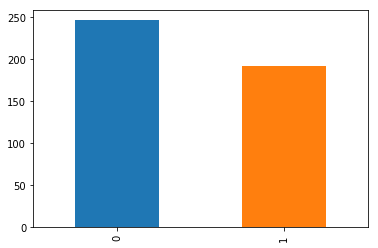

In [5]:
df['category'].value_counts().plot.bar()

In [8]:
img_height,img_width = 480,744
num_classes = 6
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(2, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 480, 744, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 486, 750, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 240, 372, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 240, 372, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [tbCallBack ,earlystop]

In [10]:
df["category"] = df["category"].replace({0: 'NG', 1: 'GO'})

In [11]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

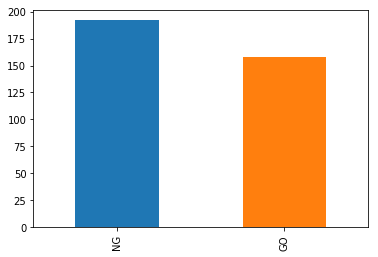

In [12]:
train_df['category'].value_counts().plot.bar()

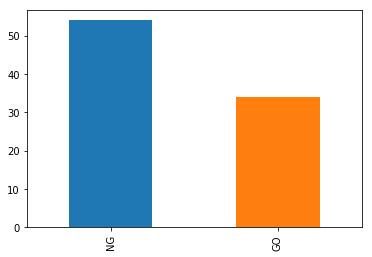

In [13]:
validate_df['category'].value_counts().plot.bar()

In [14]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=10

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255,)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 350 validated image filenames belonging to 2 classes.


In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=20
)

Found 88 validated image filenames belonging to 2 classes.


In [17]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=10,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
35/35 [==============================] - 30s 857ms/step - loss: 1.3040 - acc: 0.6029 - val_loss: 1.6349 - val_acc: 0.7045
Epoch 2/50
35/35 [==============================] - 22s 635ms/step - loss: 1.0771 - acc: 0.6629 - val_loss: 0.9629 - val_acc: 0.7159
Epoch 3/50
35/35 [==============================] - 22s 638ms/step - loss: 1.0009 - acc: 0.7343 - val_loss: 3.0319 - val_acc: 0.6136
Epoch 4/50
35/35 [==============================] - 23s 647ms/step - loss: 0.9605 - acc: 0.7114 - val_loss: 0.7688 - val_acc: 0.7386
Epoch 5/50
35/35 [==============================] - 22s 640ms/step - loss: 0.6227 - acc: 0.7743 - val_loss: 3.1100 - val_acc: 0.4091
Epoch 6/50
35/35 [==============================] - 22s 642ms/step - loss: 0.6215 - acc: 0.8200 - val_loss: 2.2942 - val_acc: 0.6364
Epoch 7/50
35/35 [==============================] - 23s 645ms/step - loss: 0.5468 - acc: 0.8171 - val_loss: 1.7219 - val_acc: 0.6705
Epoch 8/50
35/35 [==============================] - 22s 639ms/step - 

In [ ]:
model.save_weights("model_res_noreduce.h5")

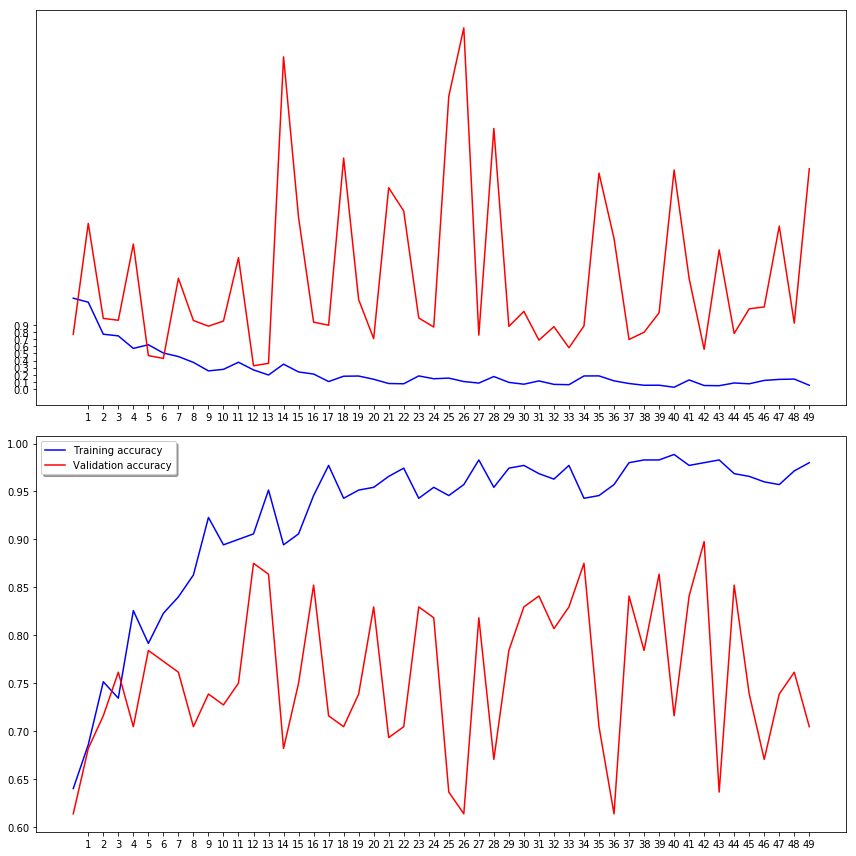

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [18]:
filenames = os.listdir("./test/")
ra_dataframe  = pd.read_csv('./rough_data.csv', header=None)
categories = []
for filename in filenames:
    dummy,right  = filename.split("_",1)
    info,right = right.split("_",1)
    number = info[0:-1]
    dire   = info[-1]
    row = 0
    if dire == 'L':
        row = (int(number) - 1)*2
    else:
        row = (int(number) - 1)*2 + 1
    ra_value = ra_dataframe.iloc[row,0]
    if ra_value < 1.6:
        categories.append(1)
    else:
        categories.append(0)
test_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
test_df

ValueError: not enough values to unpack (expected 2, got 1)

In [27]:
test_filenames = os.listdir("./test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [28]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 18 validated image filenames.


In [29]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [30]:
test_df['category'] = np.argmax(predict, axis=-1)

In [31]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [32]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

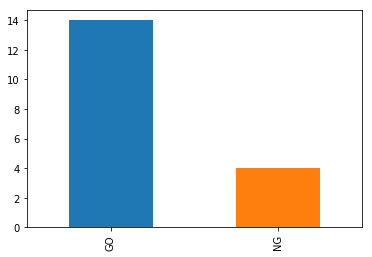

In [33]:
test_df['category'].value_counts().plot.bar()

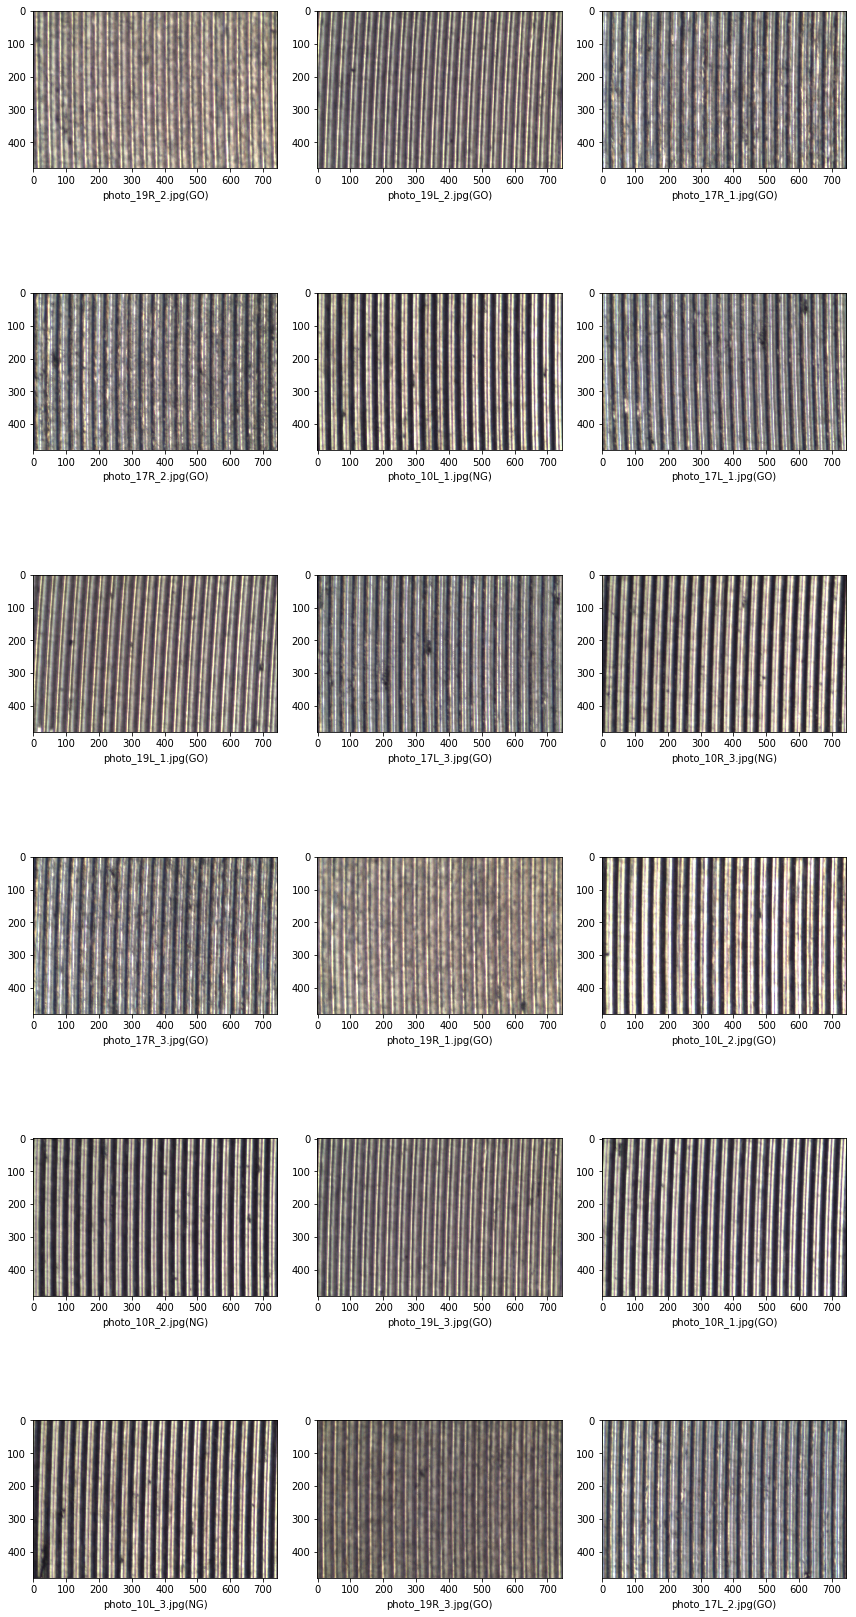

In [34]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()